# Correlation Matrix with Pytorch

In [1]:
%load_ext autoreload

In [2]:
import os
import sys
print(os.listdir('../'))

['pyproject.toml', 'report', 'weights', 'notebooks', 'requirements.txt', 'data', '.gitignore', 'README.md', 'Makefile', 'parkinson', '.git']


In [3]:
import sys
# sys.path.append('/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning')
sys.path.append('../')

import os
import time
    
import parkinson

import torch
from torch import nn

import pandas as pd
import networkx as nx
import numpy as np

import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [4]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
CORR_METHOD = "ledoit_wolf"  # método de matriz de correlação: dtw, pearson, spearman, icoh (no graph.py)

## Data Processing
### Reading

In [5]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')

control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

100%|██████████| 66/66 [00:01<00:00, 36.57it/s]


total de pacientes: 219

In [6]:
parkinson_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(
    parkinson_atlas_data, method=CORR_METHOD, group='parkinson'
)

In [7]:
control_correlation_matrix = parkinson.utils.graph.compute_correlation_matrix(
    control_atlas_data, method=CORR_METHOD, group='control'
)

In [8]:
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])

X, y = parkinson.utils.data.filter_data(X, y)

### Split  
- 60% treino
- 20% validação
- 20% teste

In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

### Dataloaders

In [10]:
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

## Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.SimpleMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

In [12]:
model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [13]:
%%time
out = parkinson.utils.train.train(model, train_loader, val_loader, class_weights, device, N_EPOCHS,  PATIENCE,LR)

train-loss: 0.2374  train-acc: 0.9396 | val-loss: 0.5731  val-acc: 0.7045:  28%|██▊       | 55/200 [00:21<00:57,  2.51it/s]

Early stopping at epoch 56
CPU times: user 13.2 s, sys: 17.6 s, total: 30.8 s
Wall time: 22.7 s


In [14]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)
print('Metrics:', metrics)
print('Done.')

Preds: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]
Metrics: {'preds': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1], 'labels': [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)], 'acc': 0.75, 'f1': 0.7295664534470504, 'recall': 0.75, 'precision': 0.732638888888889}
Done.


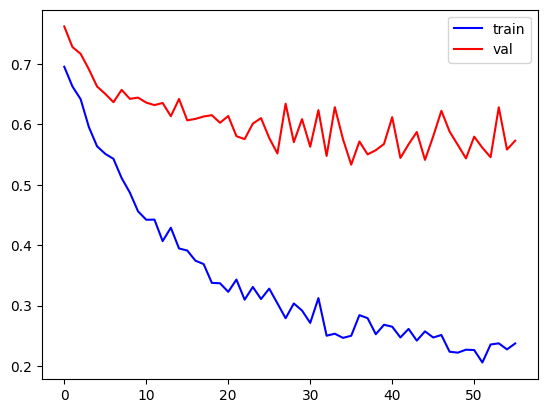

In [15]:
parkinson.utils.results.plot_losses(out['train_loss'], out['val_loss'])